# INITIALIZATION

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "your path here"
!ls

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn.metrics as sk_metrics
import seaborn as sns
import pathlib
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import datasets
from random import randint
import tensorflow_datasets as tfds

In [4]:
IMG_SIZE = [128, 128]
IMG_SIZE_TUPLE = (IMG_SIZE[0], IMG_SIZE[1])
BATCH_SIZE = 16
IMG_SHAPE = IMG_SIZE_TUPLE + (3,)

In [5]:
#%cd ..
#!ls

/content/drive/MyDrive/MIUN_23-24/PROJECT
 acoustic_emission_outputs.csv						  EFF_net
 application1.15.ipynb							  images
 applicationcopy.ipynb							  my_model.h5
'Copy of Kopija dokumenta Copy of TransferLearningAddedQuantTest.ipynb'   trained_model
 Dataset								  trained_model_2.tflite
 Dataset_split.zip							  trained_model.tflite
 Dataset.zip


In [6]:
#!unzip -q train.zip
#!unzip -q test.zip
#!unzip -q val.zip
#!unzip -q Dataset.zip
#!unzip -q Dataset_split.zip

# LOAD DATASET FROM SPLIT FOLDERS

In [21]:
train_dataset = image_dataset_from_directory('../train',
          batch_size=BATCH_SIZE,
          image_size=IMG_SIZE,
          interpolation='nearest',
          label_mode='categorical' # yields "one-hot" vectors for output
          )
test_dataset = image_dataset_from_directory('../test',
          batch_size=BATCH_SIZE,
          image_size=IMG_SIZE,
          interpolation='nearest',
          label_mode='categorical' # yields "one-hot" vectors for output
          )
val_dataset = image_dataset_from_directory('../val',
          batch_size=BATCH_SIZE,
          image_size=IMG_SIZE,
          interpolation='nearest',
          label_mode='categorical' # yields "one-hot" vectors for output
          )

Found 5375 files belonging to 26 classes.
Found 148 files belonging to 26 classes.
Found 133 files belonging to 26 classes.


In [6]:
class_names = train_dataset.class_names
class_number = len(class_names)

# LOAD DATASET FROM SINGLE FOLDER

In [5]:
dataset = image_dataset_from_directory('../Dataset',
          shuffle=True,
          batch_size=None,
          image_size=IMG_SIZE,
          interpolation='nearest',
          label_mode='categorical' # yields "one-hot" vectors for output
          )
nbr_batches = tf.data.experimental.cardinality(dataset)
val_dataset = dataset.take(nbr_batches // 5)
test_dataset = val_dataset.take(nbr_batches // 2)
train_dataset = dataset.skip(nbr_batches // 5)

Found 1356 files belonging to 26 classes.


In [6]:
count = 0
for i in val_dataset:
  count += 1
print(count)

271


In [20]:
from imgaug import augmenters as iaa
augmenter = iaa.Sequential([
    iaa.Sometimes(0.3, iaa.MotionBlur((3, 4)), name='SometimesMotionBlur'),
    iaa.Sometimes(0.3, iaa.GaussianBlur((0.0, 0.75)), name='SometimesGaussianBlur'),
    iaa.GammaContrast((0.7, 1.5)),
    iaa.MultiplySaturation((0.9, 1.5)),
    iaa.MultiplyAndAddToBrightness(),
    #NEW AUGMENTATIONS
    iaa.ScaleX((0.5, 1.5), mode="edge"),
    iaa.ScaleY((0.5, 1.5), mode="edge")
])
def augmentation_function(images, labels):
    img_dtype = images.dtype
    img_shape = tf.shape(images)
    images = tf.numpy_function(augmenter.augment_images,
                                [images],
                                img_dtype)
    images = tf.reshape(images, shape=img_shape)
    return images, labels
def augment_image_multiple_times(image, label):
    # Create a dataset from the image and label
    ds = tf.data.Dataset.from_tensors((image, label))
    # Repeat the dataset 4 times for augmentation
    ds_augmented = ds.repeat(4)
    # Apply the augmentation function to each image
    ds_augmented = ds_augmented.map(augmentation_function, num_parallel_calls=tf.data.AUTOTUNE)
    # Concatenate the original image with the augmented images
    ds = ds.concatenate(ds_augmented)
    return ds

In [21]:
train_dataset = train_dataset.flat_map(augment_image_multiple_times)

In [ ]:
num_samples = train_dataset.reduce(0, lambda x, _: x + 1)
#num_samples = train_dataset.cardinality().numpy() * 16
print(num_samples)
#num_samples = test_dataset.reduce(0, lambda x, _: x + 1)
num_samples = test_dataset.cardinality().numpy() * 16
print(num_samples)
#num_samples = val_dataset.reduce(0, lambda x, _: x + 1)
num_samples = val_dataset.cardinality().numpy() * 16
print(num_samples)

tf.Tensor(350, shape=(), dtype=int32)
272
272


In [22]:
class_names = dataset.class_names
class_number = len(class_names)
IMG_SHAPE = IMG_SIZE_TUPLE + (3,)

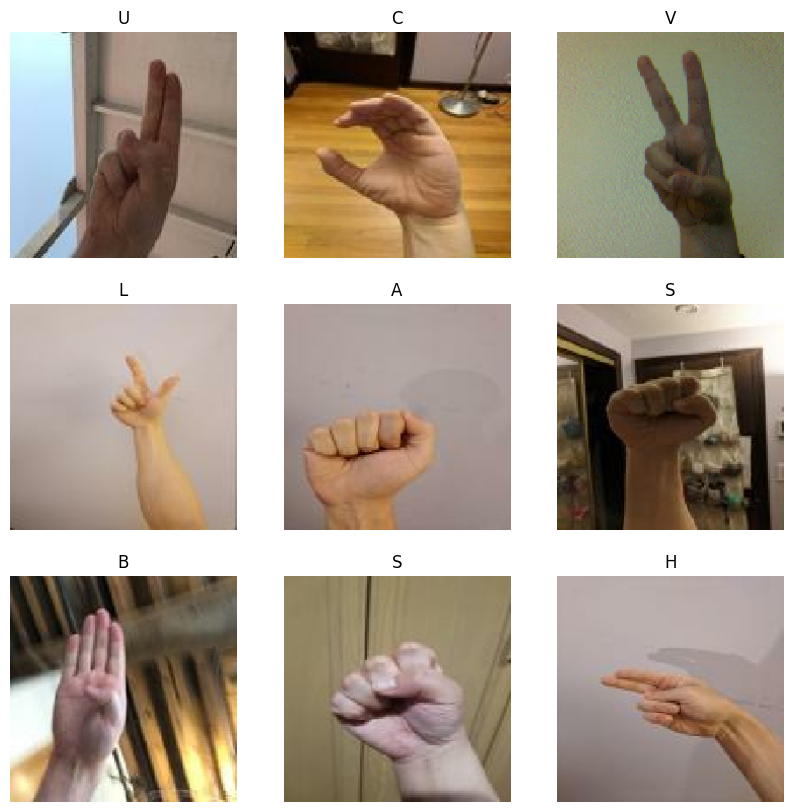

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis('off')

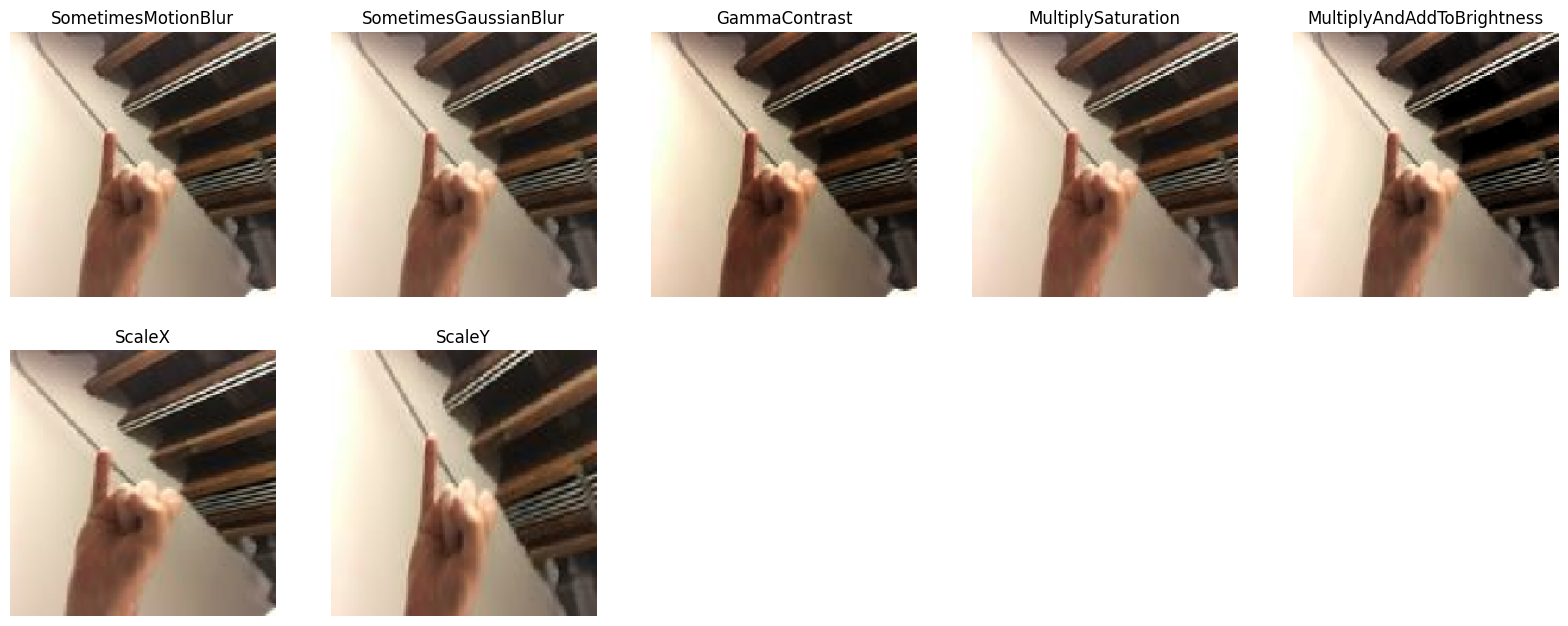

In [10]:
# Run this cell several times to see the effect of different data augmentation
image, _ = next(iter(train_dataset.unbatch().batch(1)))
plt.figure(figsize=(20, 20))
img_dtype = image.dtype
for i, augment in enumerate(augmenter):
  ax = plt.subplot(5, 5, i + 1)
  augmented_image = tf.numpy_function(augment.augment_images,
                                      [image],
                                      img_dtype)
  ax.set_title(augment.name.replace('Unnamed', ''))
  plt.imshow(augmented_image[0])
  plt.axis('off')

# MBNv3

In [22]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return (tf.cast(image, tf.float32) / 255.0) * 2 - 1, label

train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [28]:
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMG_SHAPE,
    alpha=1.0,
    minimalistic=True,
    include_top=False,
    weights='imagenet',
    include_preprocessing=False,
)

# MBNv2

In [7]:
normalization = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                                                alpha=0.35,
                                                                include_top=False,
                                                                weights='imagenet')

In [8]:
train_dataset = train_dataset.map(lambda img, label: (normalization(tf.cast(img, tf.float32)), label), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda img, label: (normalization(tf.cast(img, tf.float32)), label), num_parallel_calls=tf.data.AUTOTUNE)


train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# MBNv1

In [7]:
normalization = tf.keras.applications.mobilenet.preprocess_input
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              alpha=0.25,
                                              include_top=False,
                                              weights="imagenet")

train_dataset = train_dataset.map(lambda img, label: (normalization(tf.cast(img, tf.float32)), label), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda img, label: (normalization(tf.cast(img, tf.float32)), label), num_parallel_calls=tf.data.AUTOTUNE)
#test_set = test_set.map(lambda img, label: (normalization(tf.cast(img, tf.float32)), label), num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

2108140/2108140 [==============================] - 1s 1us/step


# BASE MODEL

In [29]:
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(class_number, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0005

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 4, 4, 576)         441000    
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 576)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 26)                15002     
                                                                 
Total params: 456002 (1.74 MB)
Trainable params: 15002 (58.

# TRAIN

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_dataset,
                        epochs=100,
                        validation_data=val_dataset, callbacks=callback)

Epoch 1/100
336/336 [==============================] - 6s 9ms/step - loss: 3.3655 - accuracy: 0.1213 - val_loss: 2.6415 - val_accuracy: 0.2030
Epoch 2/100
336/336 [==============================] - 2s 6ms/step - loss: 2.5269 - accuracy: 0.2614 - val_loss: 2.2416 - val_accuracy: 0.3609
Epoch 3/100
336/336 [==============================] - 2s 6ms/step - loss: 2.1142 - accuracy: 0.3587 - val_loss: 2.0177 - val_accuracy: 0.4135
Epoch 4/100
336/336 [==============================] - 2s 6ms/step - loss: 1.9016 - accuracy: 0.4264 - val_loss: 1.8960 - val_accuracy: 0.4361
Epoch 5/100
336/336 [==============================] - 3s 9ms/step - loss: 1.7151 - accuracy: 0.4789 - val_loss: 1.7878 - val_accuracy: 0.4812
Epoch 6/100
336/336 [==============================] - 3s 8ms/step - loss: 1.5841 - accuracy: 0.5187 - val_loss: 1.7022 - val_accuracy: 0.5038
Epoch 7/100
336/336 [==============================] - 2s 7ms/step - loss: 1.5122 - accuracy: 0.5412 - val_loss: 1.6510 - val_accuracy: 0.5113

# FINE TUNING

In [31]:
#SAVE THE BASE MODEL
base_model = model

In [32]:
callback_fine_tune = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history_fine_tune = model.fit(train_dataset, epochs=100,validation_data=val_dataset, callbacks=callback_fine_tune)

Epoch 1/100
336/336 [==============================] - 79s 27ms/step - loss: 0.9291 - accuracy: 0.7098 - val_loss: 1.2970 - val_accuracy: 0.5865
Epoch 2/100
336/336 [==============================] - 8s 22ms/step - loss: 0.8455 - accuracy: 0.7325 - val_loss: 1.2491 - val_accuracy: 0.6165
Epoch 3/100
336/336 [==============================] - 9s 27ms/step - loss: 0.7874 - accuracy: 0.7537 - val_loss: 1.2127 - val_accuracy: 0.6241
Epoch 4/100
336/336 [==============================] - 7s 22ms/step - loss: 0.7210 - accuracy: 0.7743 - val_loss: 1.2014 - val_accuracy: 0.6090
Epoch 5/100
336/336 [==============================] - 9s 27ms/step - loss: 0.6804 - accuracy: 0.7792 - val_loss: 1.1688 - val_accuracy: 0.6316
Epoch 6/100
336/336 [==============================] - 8s 23ms/step - loss: 0.6446 - accuracy: 0.8017 - val_loss: 1.1395 - val_accuracy: 0.6316
Epoch 7/100
336/336 [==============================] - 8s 23ms/step - loss: 0.5859 - accuracy: 0.8117 - val_loss: 1.1151 - val_accuracy

# VISUALIZE RESULTS

Text(0.5, 0, 'epoch')

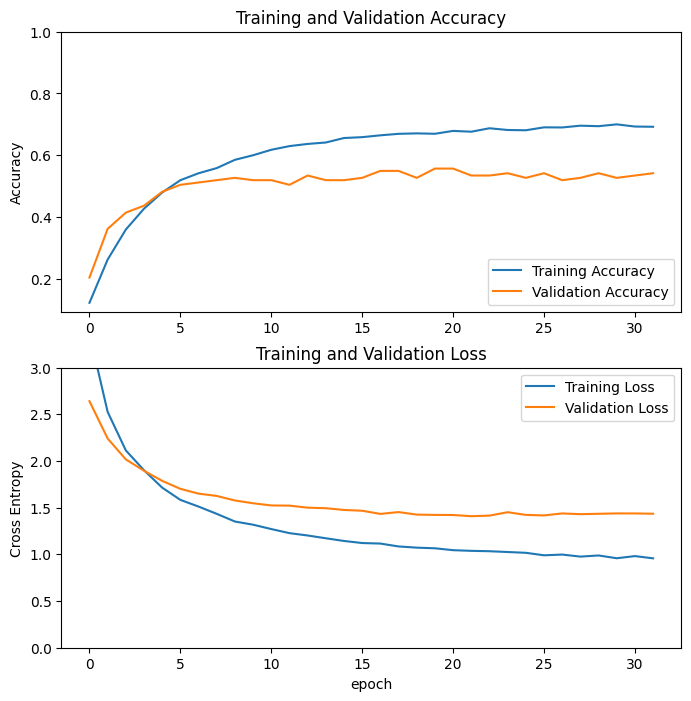

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

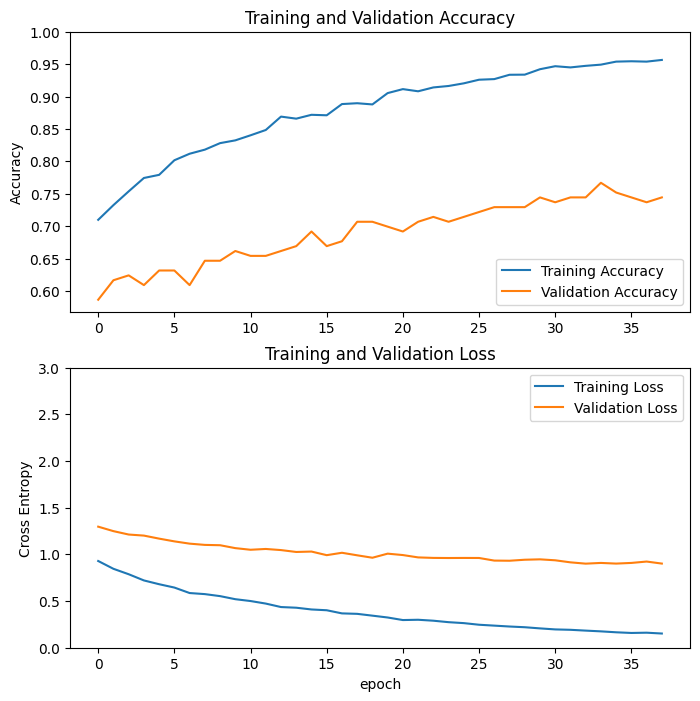

In [34]:
acc = history_fine_tune.history['accuracy']
val_acc = history_fine_tune.history['val_accuracy']
loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

In [11]:
#from tensorflow.keras.models import load_model
#model = load_model('my_model_v2.h5')

In [35]:
test_set = test_dataset.cache()
#test_set = test_set.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_set = test_set.map(lambda img, label: (normalization(tf.cast(img, tf.float32)), label), num_parallel_calls=tf.data.AUTOTUNE)

Evaluate on test data
10/10 [==============================] - 1s 70ms/step - loss: 0.6434 - accuracy: 0.7905
test loss: 0.6434211730957031, test acc: 0.7905405163764954
10/10 [==============================] - 1s 5ms/step
F1 score is: 0.7905405405405406


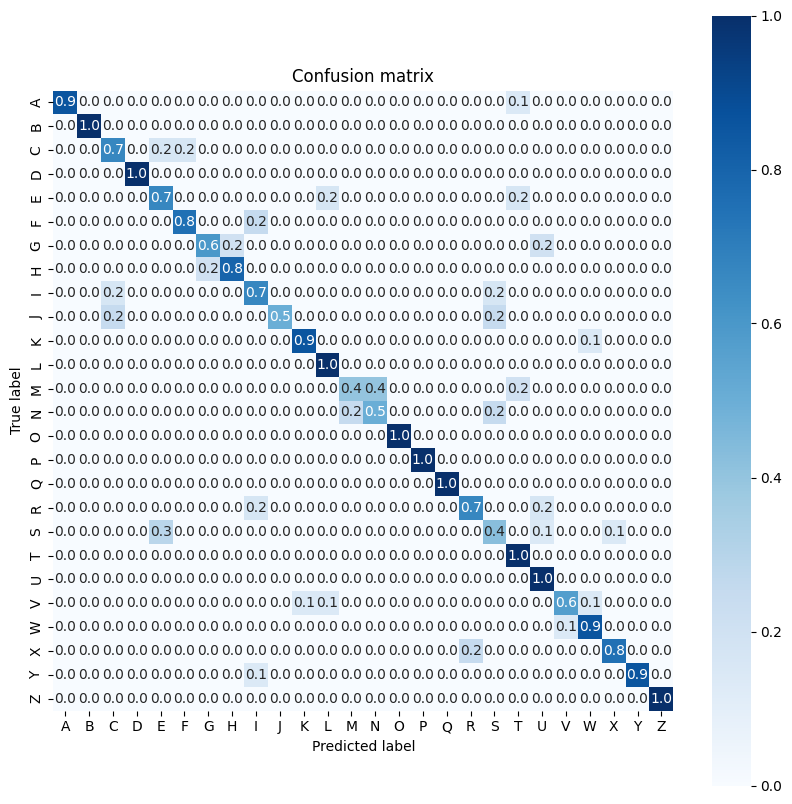

In [36]:

print("Evaluate on test data")
results = model.evaluate(test_set)
print(f"test loss: {results[0]}, test acc: {results[1]}")
predictions = model.predict(test_set)
predictions = tf.argmax(predictions, axis=1)
true_categories = tf.argmax( np.concatenate([y for x, y in test_set], axis=0), axis=1)

f1 = sk_metrics.f1_score(true_categories, predictions, average='micro')
print("F1 score is: "+str(f1))

confusion = sk_metrics.confusion_matrix(true_categories, predictions)
confusion_normalized = [element/sum(row) for element, row in zip([row for row in confusion], confusion)]
axis_labels = list(class_names)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels, cmap='Blues',
                  annot=True,
                  fmt='.1f', square=True)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label");

In [37]:
model.save('my_model_v3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# TRNANSFORM TO LITE

In [38]:

def representative_data_gen():
  for x, y in val_dataset.take(100):
    yield [x]

# Needed for quantization in case of unfrozen MobileNet model
model.trainable = False
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

import pathlib
tflite_model_quant = converter.convert()
tflite_model_quant_file = pathlib.Path("./model_quant_v3.tflite")
tflite_model_quant_file.write_bytes(tflite_model_quant)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


630960

In [39]:
# Initialize the interpreter
interpreter = tf.lite.Interpreter(model_path=str("model_quant_v3.tflite"))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

quant_correct_predictions = 0
quant_incorrect_predictions = 0

q_pred = []
q_real = []

for (image, true_category) in test_dataset.unbatch():
  test_image = image
  #test_image = tf.cast(image, tf.uint8)
  #test_image = (test_image / 255.0) * 2 - 1
  test_label = tf.argmax(true_category)

  # Check if the input type is quantized, then rescale input data to uint8
  if input_details['dtype'] == np.uint8:
    #input_scale, input_zero_point = input_details["quantization"]
    #test_image = test_image / input_scale + input_zero_point
    #test_image = (test_image / 255.0) * 2 - 1
    pass


  test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
  interpreter.set_tensor(input_details["index"], test_image)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details["index"])[0]
  if(output.argmax() == test_label):
    quant_correct_predictions += 1
  else:
    quant_incorrect_predictions += 1

  q_pred.append(output.argmax())
  q_real.append(test_label)

print(f'Accuracy : {quant_correct_predictions / (quant_correct_predictions + quant_incorrect_predictions)}')
q_f1 = sk_metrics.f1_score(q_real, q_pred, average='micro')
print("F1 : "+ str(q_f1))

Accuracy : 0.5743243243243243
F1 : 0.5743243243243243
